# **Segmentación de Clientes**

El objetivo de este proyecto identificar y describir segmentos (grupos) de clientes en función del patrón de su consumo anual (en unidades monetarias) en diversas categorías de productos. Más información de este dataset aquí: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers


## **Leer Dataset**

In [87]:
import pandas as pd
customers = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWC/data/wholesale_customers_data.csv")
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


El atributo Channel indica si el cliente pertenece a un Horeca (hotel, restaurant o cafe) o es Retail (minorista). El atributo Region indica si la compra fue realizada en Lisboa, Oporto u otra ciudad.

Según la información del dataset encontrada en el link anterior la frecuencia de Region es:

Lisboa 77, Oporto 47, Otra 316

Y la frecuencia de Channel es:

Horeca 298 y Retail 142.

Veamos mediante histogramas con qué valor numérico se identifican estas variables nominales.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


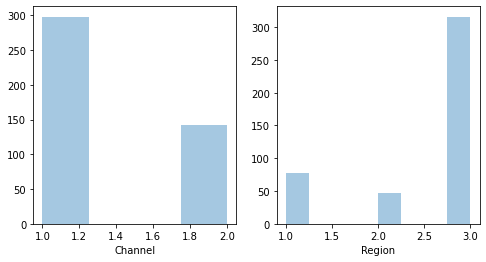

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(8,4))

sns.distplot(customers['Channel'], kde=False, ax=axes[0])
sns.distplot(customers['Region'], kde=False, ax=axes[1])

Vemos que para el atributo Channel: Horeca = 1 y Retail = 2. Y para Region: Lisboa = 1, Oporto = 2 y Otra = 3.

Estos atributos los puedo pensar como categorías en sí. Por lo tanto para realizar el clustering no los voy a considerar y luego veré si los clusters generados por los distintos algoritmos utilizados coinciden con esta segmentación

In [89]:
clientes = customers.drop(columns=['Channel', 'Region'])
clientes.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


Relicemos un pairplot en busca de correlación entre los datos.

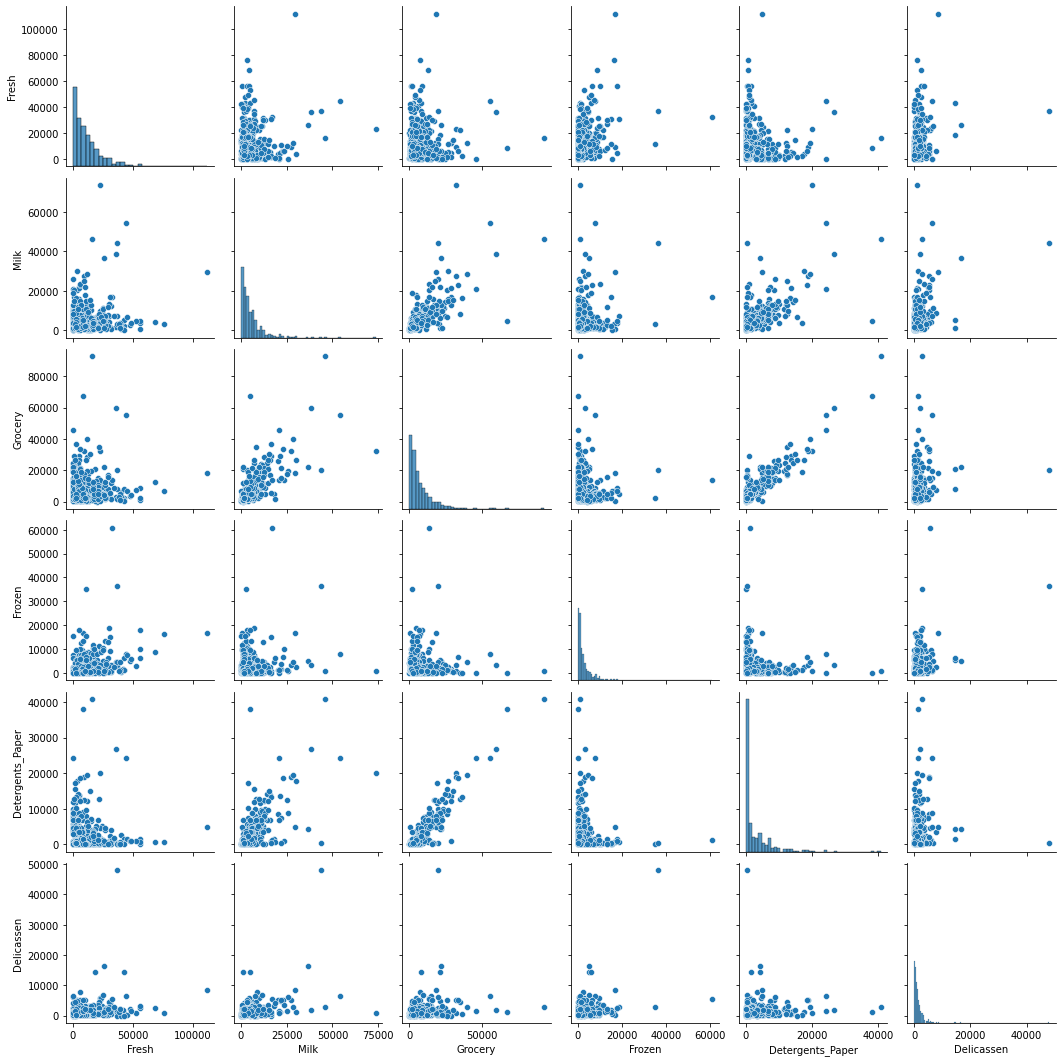

In [90]:
sns.pairplot(clientes)

Observo cierta correlación entre los atributos 'Milk' y 'Grocery' así como entre 'Grocery' y 'Detergents_Paper'. Vamos a cuantificarlas

In [91]:
clientes.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


Se ve que el par que mayor correlación presenta es 'Grocery-Detergents_Paper'. Podré utilizar este par luego para mostrar la clusterización.

Antes de aplicar cualquier algoritmo de clustering al dataset procedo a estandarizar los datos para que ninguno tenga mayor peso.

In [92]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x = np.array(clientes)
scaler.fit(x)
x = scaler.transform(x)

## **K-means**

Para comenzar aplicaré el algoritmo K-means al dataset en busca de clusters. Como dato de entrada hay que especificar manualmente cuántos clusters queremos. Otra cuestión importante es la inicialización de centroides de estos clusters. Vamos a jugar un poco con estos parámetros en busca del mejor modelo.

Comenzaré eligiendo 2 clusters, luego 3 y por último aplicaré la "regla del codo" para determinar el número óptimo de clusters. Con 2 y 3 quiero comparar el clustering con los atributos 'Channel' y 'Region', respectivamente.

Además probaré con los métodos de inicialización 'kmeans++' ("smart way" to speed up convergence) y 'random' para ver las diferencias. La idea es inicializar con distintos centroides para encontrar la mejor segmentación para un número determinado de clusters (esto lo logro con 'n_init'). 

In [93]:
from sklearn import metrics

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    estimator = kmeans.fit(data)
    results = [name, estimator.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator.labels_,
                                 metric="euclidean", sample_size=300)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [94]:
from sklearn.cluster import KMeans

print('init\t\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

channel_labels = np.array(customers['Channel'])
channel_labels = channel_labels - [1]*channel_labels.shape[0]   #Le resto 1 a todos los elementos para que me queden 0s y 1s

kmeans = KMeans(init="k-means++", n_clusters=2, n_init=5,random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=x, labels=channel_labels)

kmeans = KMeans(init="random", n_clusters=2, n_init=5, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=x, labels=channel_labels)

init		inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1955	0.153	0.261	0.193	0.237	0.191	0.573
random   	1955	0.167	0.318	0.219	0.231	0.217	0.575


Lo que observo es que las métricas arrojadas por ambos métodos utilizando K-means son bastante malas a la hora de intentar segmentar los clientes en 2 clusters comparando con la categoría Channel. Lo que supongo es que quizás los datos no estén separados por si los clientes son 'horeca' o 'retail'. Veamos en un gráfico utilizando el par 'Grocery-Detergents_Paper'.

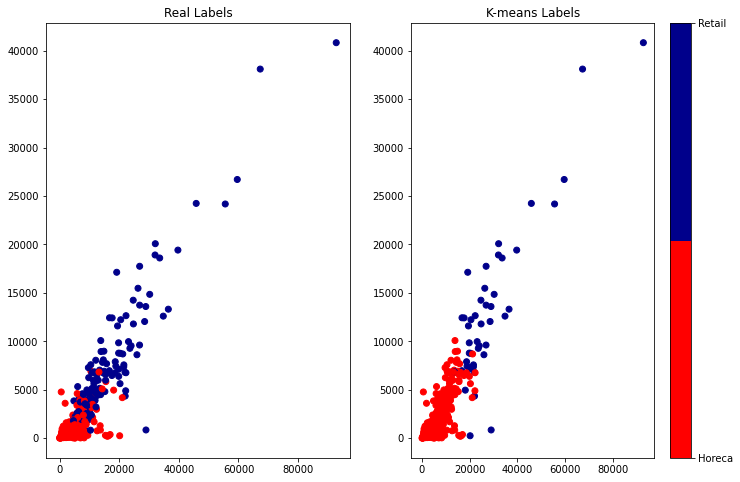

In [95]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(12, 8))

etiquetas = ['Horeca','Retail']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue'])

plt.subplot(1,2,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=channel_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,2,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans.labels_, cmap=cmap_scatter)
plt.title("K-means Labels")

plt.colorbar(ticks=[0, 1], format=formatter)

Lo que observo es que sí hay cierta segmentación en los datos en función del atributo 'Channel', pero esta segmentación no está tan bien definida. Hay una región donde los datos se "mezclan" bastante. Por esto es que el modelo no es capaz de describir los clusters correctamente. Quizás haya algoritmos que sí lo puedan hacer. Más adelante lo veré.

Intentemos ahora con 3 clusters para comparar con la etiqueta 'Region'.

In [96]:
print('init\t\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

region_labels = np.array(customers['Region'])
region_labels = region_labels - [1]*region_labels.shape[0] #Le resto 1 a todos los elementos para que me queden 0s , 1s y 2s

kmeans = KMeans(init="k-means++", n_clusters=3, n_init=5,random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=x, labels=region_labels)

kmeans = KMeans(init="random", n_clusters=3, n_init=5, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=x, labels=region_labels)

init		inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1620	0.001	0.001	0.001	-0.004	-0.006	0.322
random   	1620	0.001	0.001	0.001	-0.004	-0.006	0.326


Observo que la clusterización en este caso no se corresponde con la etiqueta 'Region'. En el gráfico debería observar que los datos no están segmentados por esta etiqueta.

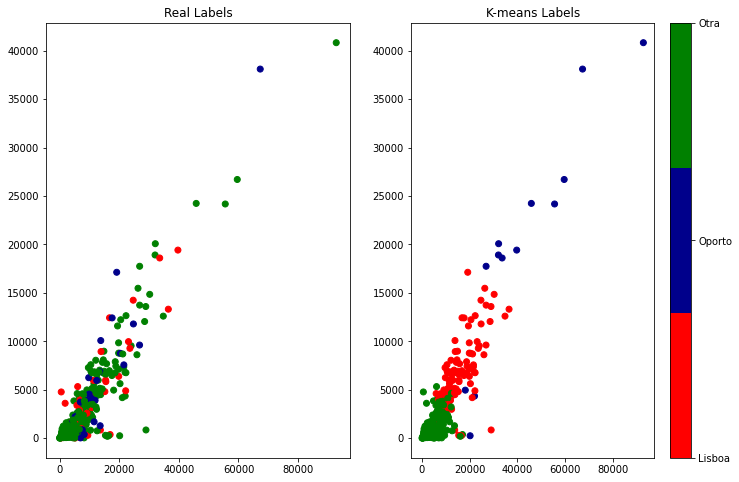

In [97]:
plt.figure(figsize=(12, 8))

etiquetas = ['Lisboa','Oporto','Otra']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue', 'green'])

plt.subplot(1,2,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=region_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,2,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans.labels_, cmap=cmap_scatter)
plt.title("K-means Labels")

plt.colorbar(ticks=[0, 1, 2], format=formatter)

Se ve claramente que la región del cliente no representa una variable que clusterice los datos.

Apliquemos ahora la "regla del codo" para ver si hay un número óptimo de clusters. Mediante este método heurístico el número óptimo se determina cuando la curva decreciente "Inercia" vs "Número de clusters" deja de descender tan bruscamente.

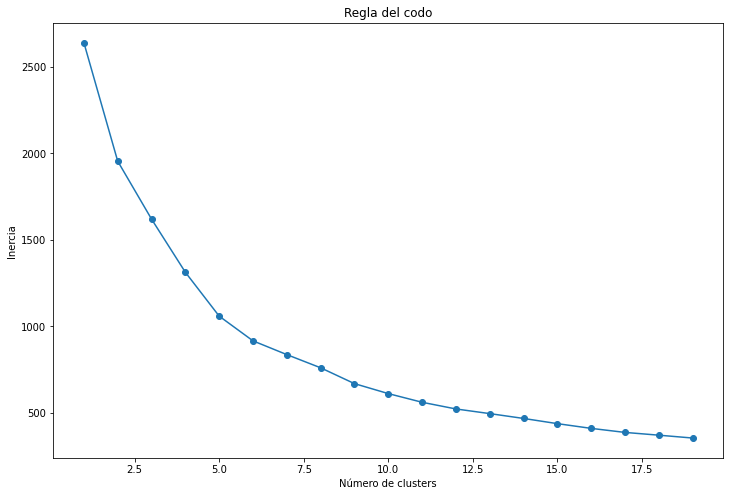

In [98]:
inercia = []

for i in range(1,20):
  kmeans = KMeans(init="k-means++", n_clusters=i, n_init=5,random_state=0)
  kmeans.fit(x)
  inercia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(1,20),inercia, marker="o")
plt.title('Regla del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

Vemos que el quiebre de la curva se presenta en 5. Entonces procedo ahora a aplicar kmeans para 5 clusters y observar cómo se forman estos clusters.

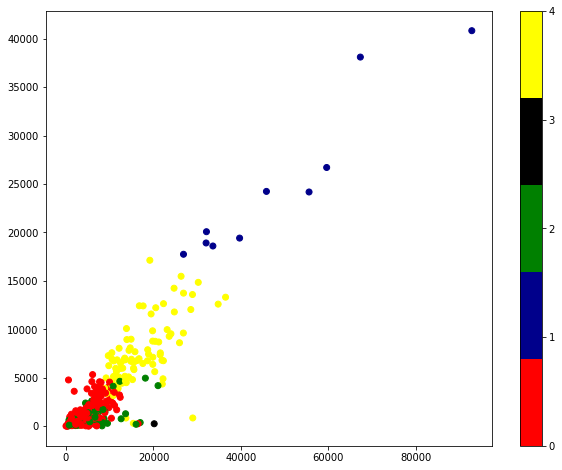

In [99]:
kmeans = KMeans(init="k-means++", n_clusters=5, n_init=5,random_state=0)
kmeans.fit(x)

plt.figure(figsize=(10, 8))

cmap_scatter = ListedColormap(['red', 'darkblue', 'green', 'black', 'yellow'])

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans.labels_, cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()

Observo que el cluster 3 consiste de 1 solo punto (punto negro) por lo que este punto puede ser incluido en otro cluster. Entonces vuelvo a aplicar K-means con 4 clusters.

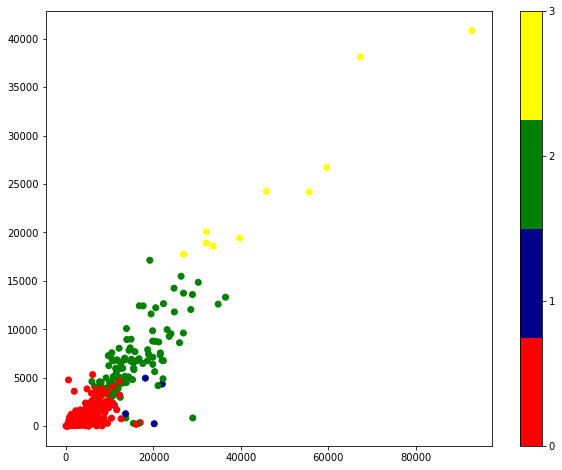

In [100]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=5,random_state=0)
kmeans.fit(x)

plt.figure(figsize=(10, 8))

cmap_scatter = ListedColormap(['red', 'darkblue', 'green', 'yellow'])

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans.labels_, cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1, 2, 3])
plt.show()

Ahora obtengo que el cluster 1 consiste de sólo 4 puntos. Por lo que se pueden absorber en los otros 3 al igual que el punto negro de antes. 

Finalmente con el algoritmo K-means observo que el número óptimo de clusters será 2 o 3. En el caso de 2 clusters los puedo asociar al canal de compra del cliente ('Horeca' o 'Retail') aunque la segmentación de los datos por parte del modelo no es la deseada. A continuación aplicaré otros algoritmos para comparar.

## **Mean Shift**

El algoritmo Mean Shift busca "manchas" en la densidad de datos. A diferencia de K-means, la máquina determina el número óptimo de clusters, no es necesario indicárselos manualmente. Como dato de entrada hay que pasarle el parámetro 'bandwith' que es el radio donde buscará posibles candidatos a pertenecer al cluster. Cuanto mayor sea este radio menos clusters predecirá el modelo. El parámetro 'bandwith' también puede ser ajustado automáticamente. Comenzaremos dejándolo ajustarse solo.

In [101]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(x, quantile=0.5)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Número estimado de clusters : %d" % n_clusters_)

Número estimado de clusters : 13


Vemos que si dejamos al bandwith ajustarse automáticamente obtenemos un número altísimo de clusters, que lo podemos ver gráficamente.

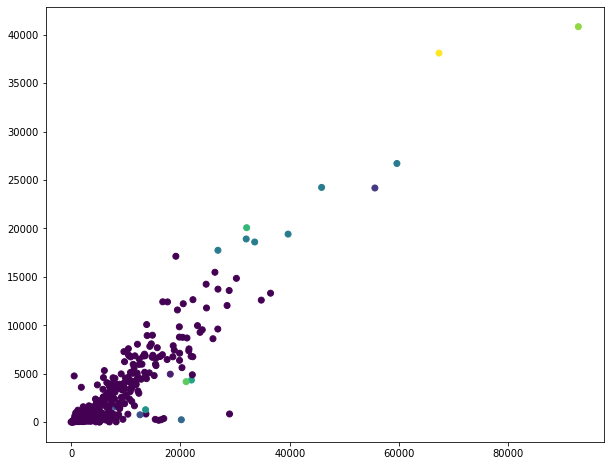

In [102]:
plt.figure(figsize=(10, 8))

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=labels)
plt.show()

Se ve que hay muchos clusters con datos individuales, debemos aumentar manualmente el valor de bandwith para mejorar el modelo. Intentemos con un valor igual a 5.

In [103]:
ms = MeanShift(bandwidth=5, bin_seeding=False, max_iter=1000)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Número estimado de clusters : %d" % n_clusters_)

Número estimado de clusters : 4


Ahora tenemos 4 clusters predichos por el modelo. Veamoslos gráficamente.

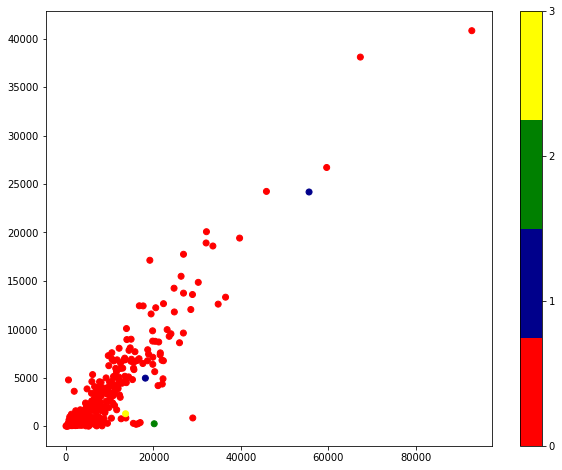

In [104]:
plt.figure(figsize=(10, 8))

cmap_scatter = ListedColormap(['red', 'darkblue', 'green', 'yellow'])

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=labels, cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1, 2, 3])
plt.show()

Lo que observo es que los clusters anteriores se acoplaron al más poblado y sigo teniendo clusters individuales. Incluso el cluster azul cuenta con 2 puntos completamente distantes entre sí. Observemos dónde se ubican los centros.

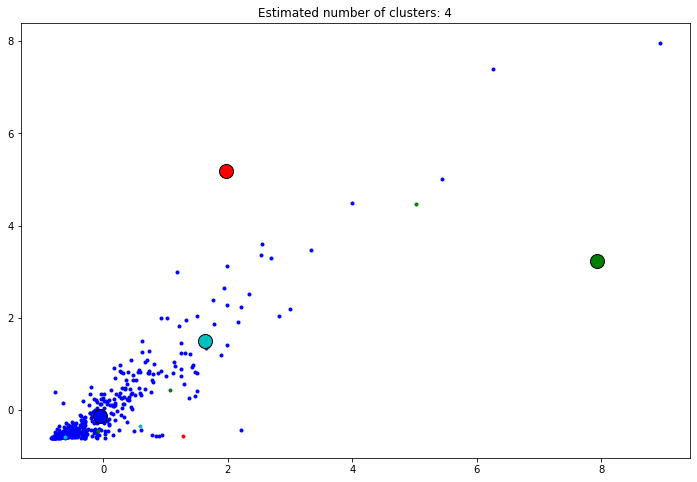

In [105]:
plt.figure(figsize=(12, 8))
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x[my_members, 2], x[my_members, 4], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Viendo los centros descubro que proyectar los datos al plano 'Grocery-Detergents_Paper' no representa las distancias correctas entre los datos. Se ve claramente en la distancia entre el centro del cluster rojo y el punto perteneciente a este cluster. Me pregunto si hay algún plano donde los datos no se "mezclen tanto" y se pueda identificar algún tipo de segmentación visualmente. Sin embargo, en las figuras del principio de pairplot esto no se observaba para ningún par de atributos. Grafico en el plano 'Grocery-Milk' para intentar ver si la segmentación se observa diferente.

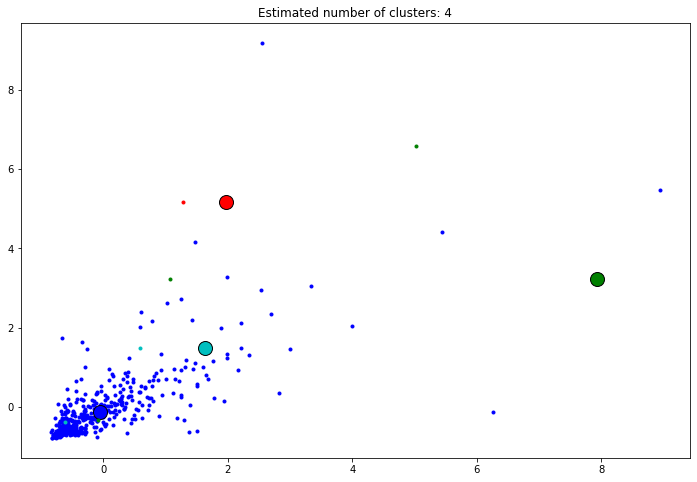

In [106]:
plt.figure(figsize=(12, 8))
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x[my_members, 2], x[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

En esta proyección de los datos observo que el punto rojo se encuentra muy cercano al centro del cluster al cual pertenece. Sin embargo, hay una gran cantidad de puntos agrupados en el cluster azul. Esto sucede por estar todos muy cercanos al cero. Quizás no haya sido una buena opción estandarizar los datos. Observemos qué ocurre con los datos originales.

In [107]:
x2 = np.array(clientes)

bandwidth = estimate_bandwidth(x2, quantile=0.5)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x2)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Número estimado de clusters : %d" % n_clusters_)
print("Bandwith : %d" % bandwidth)

Número estimado de clusters : 11
Bandwith : 18322


In [108]:
ms = MeanShift(bandwidth=40000, bin_seeding=True)
ms.fit(x2)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Número estimado de clusters : %d" % n_clusters_)

Número estimado de clusters : 3


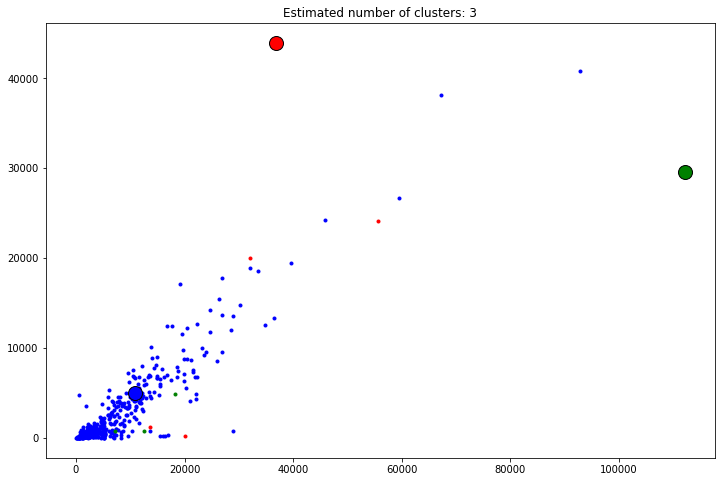

In [109]:
plt.figure(figsize=(12, 8))
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x2[my_members, 2], x2[my_members, 4], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Sigue ocurriendo lo mismo, que el cluster azul es el más poblado y los demás cuentan con muy poca cantidad de puntos. Quizás el algoritmo Mean Shift no sea el adecuado para segmentar estos datos. Por lo tanto, decido seguir probando con otros algoritmos.

## **Agglomerative Clustering**

Agglomerative Clustering es un tipo de clustering jerárquico donde cada dato empieza en un cluster individual y luego los clusters se van uniendo para formar clusters más representativos. Como dato de entrada es necesario pasarle la cantidad de clusters a los que tiene que converger. Además mediante el atributo 'linkage' se le indica qué criterio usar a la hora de la optimización. Probaremos con los distintos criterios para ver qué se obtiene.

In [126]:
#Defino una función similar a la de kmeans para comparar

def bench_agglomerative(model, name, data, labels):

    estimator = model.fit(data)
    results = [name]

    # Define the metrics which require only the true labels and estimator labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [127]:
from sklearn.cluster import AgglomerativeClustering

print('linkage\t\thomo\tcompl\tv-meas\tARI\tAMI')

agglomerative = AgglomerativeClustering(n_clusters=2, linkage='ward')
#Utilizo la misma función que para k_means para comparar entre los distintos criterios
bench_agglomerative(model=agglomerative, name="ward", data=x, labels=channel_labels)

agglomerative = AgglomerativeClustering(n_clusters=2, linkage='complete')
bench_agglomerative(model=agglomerative, name="complete", data=x, labels=channel_labels) 

agglomerative = AgglomerativeClustering(n_clusters=2, linkage='average')
bench_agglomerative(model=agglomerative, name="average", data=x, labels=channel_labels) 

agglomerative = AgglomerativeClustering(n_clusters=2, linkage='single')
bench_agglomerative(model=agglomerative, name="single", data=x, labels=channel_labels) 

linkage		homo	compl	v-meas	ARI	AMI
ward     	0.012	0.107	0.022	0.023	0.018
complete 	0.001	0.055	0.003	-0.002	-0.002
average  	0.001	0.055	0.003	-0.002	-0.002
single   	0.001	0.055	0.003	-0.002	-0.002


Vemos que las métricas son bastante malas. Observemos el gráfico para el caso de 'ward'

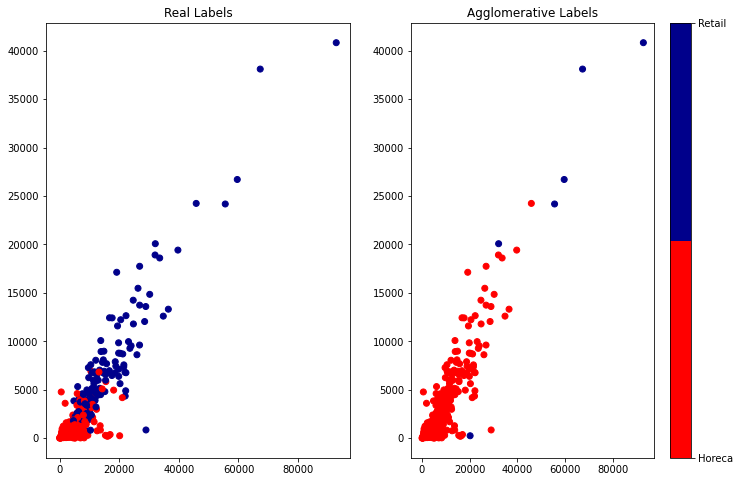

In [128]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='ward')
agglomerative.fit(x)

plt.figure(figsize=(12, 8))

etiquetas = ['Horeca','Retail']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue'])

plt.subplot(1,2,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=channel_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,2,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=agglomerative.labels_, cmap=cmap_scatter)
plt.title("Agglomerative Labels")

plt.colorbar(ticks=[0, 1], format=formatter)

Observamos que este algoritmo no agrupa adecuadamente en 2 clusters, o por lo menos como hubiera deseado. Intentemos pasándole 3 clusters como dato de entrada.

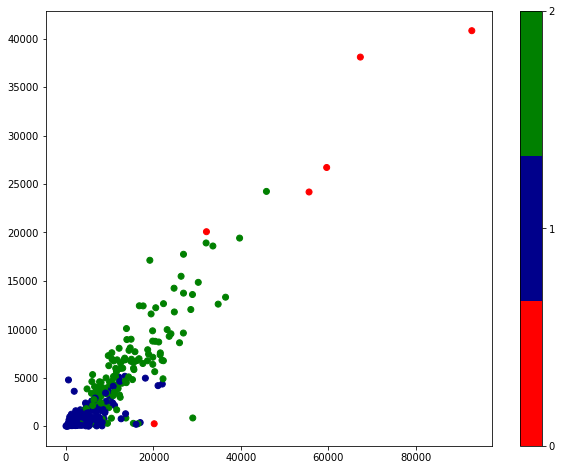

In [129]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward')
agglomerative.fit(x)

plt.figure(figsize=(10, 8))

cmap_scatter = ListedColormap(['red', 'darkblue', 'green'])

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=agglomerative.labels_, cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1, 2])
plt.show()

Observamos que para 3 clusters el modelo se comporta mejor obteniendo clusters bien definidos. Viendo que el cluster rojo cuenta solamente con 6 datos, decido agruparlos dentro del cluster verde y comparar con las etiquetas Channel.

In [146]:
agglomerative_labels = np.where(agglomerative.labels_ == 2, 0, agglomerative.labels_)
agglomerative_labels = (agglomerative_labels - [1]*agglomerative_labels.shape[0])*(-1)

clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    
results = [m(channel_labels, agglomerative_labels) for m in clustering_metrics]
    
print('homo\tcompl\tv-meas\tARI\tAMI')
# Show the results
formatter_result = ("{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}")
print(formatter_result.format(*results))

homo	compl	v-meas	ARI	AMI
0.376	0.361	0.368	0.491	0.367


Las métricas mejoraron bastante respecto a lo anterior, incluso resultan ser mejores que utilizando el algoritmo k-means. Comparemos los gráficos.

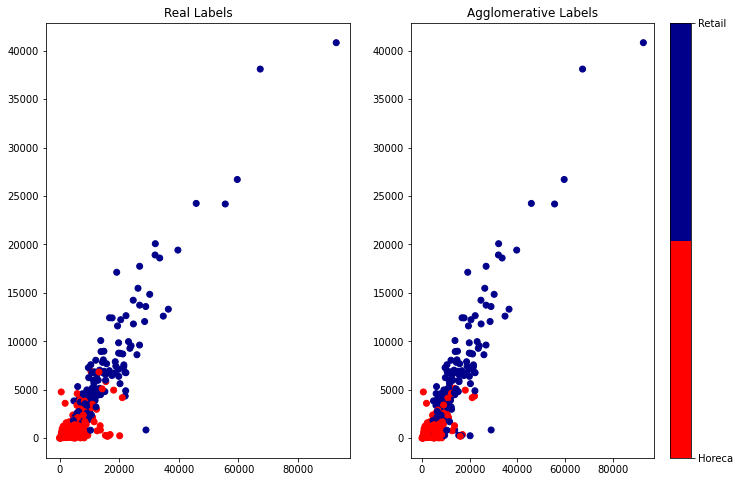

In [147]:
plt.figure(figsize=(12, 8))

etiquetas = ['Horeca','Retail']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue'])

plt.subplot(1,2,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=channel_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,2,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=agglomerative_labels, cmap=cmap_scatter)
plt.title("Agglomerative Labels")

plt.colorbar(ticks=[0, 1], format=formatter)

A partir de estas figuras vemos que los clusters obtenidos mediante el método Agglomerative Clusters se asemejan a los clusters reales del atributo Channel, con discrepancias en la zona de mayor aglomeración.

Podría intentar hacer lo mismo para el caso de kmeans. Agrupar en 3 clusters y luego juntar dos. Veamos

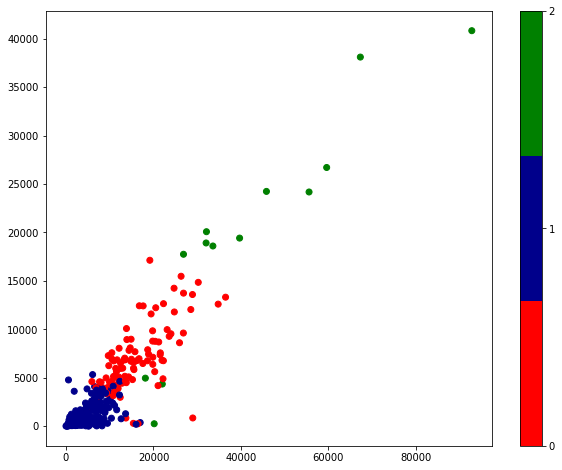

In [141]:
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=5,random_state=0)
kmeans.fit(x)

plt.figure(figsize=(10, 8))

cmap_scatter = ListedColormap(['red', 'darkblue', 'green'])

plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans.labels_, cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1, 2])
plt.show()

In [148]:
kmeans_labels = np.where(kmeans.labels_ == 2, 0, kmeans.labels_)
kmeans_labels = (kmeans_labels - [1]*kmeans_labels.shape[0])*(-1)

clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    
results = [m(channel_labels, kmeans_labels) for m in clustering_metrics]
    
print('homo\tcompl\tv-meas\tARI\tAMI')
# Show the results
formatter_result = ("{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}")
print(formatter_result.format(*results))

homo	compl	v-meas	ARI	AMI
0.395	0.421	0.408	0.544	0.406


Vemos que de esta forma las métricas suben muchísimo y dan mejor que para el caso de agglomerative clustering. Veamos el gráfico

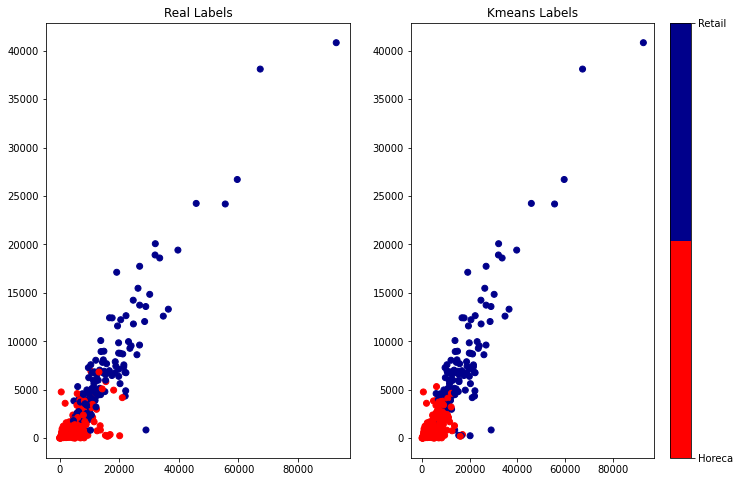

In [149]:
plt.figure(figsize=(12, 8))

etiquetas = ['Horeca','Retail']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue'])

plt.subplot(1,2,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=channel_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,2,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans_labels, cmap=cmap_scatter)
plt.title("Kmeans Labels")

plt.colorbar(ticks=[0, 1], format=formatter)

Comparemos entre los dos algoritmos

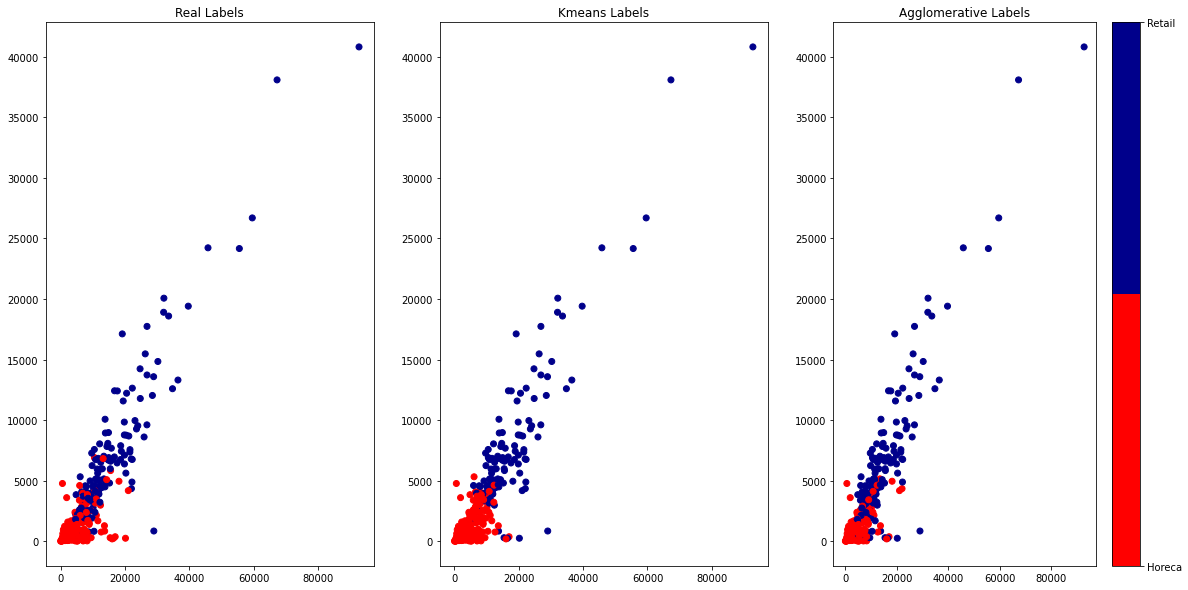

In [152]:
plt.figure(figsize=(20, 10))

etiquetas = ['Horeca','Retail']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])
cmap_scatter = ListedColormap(['red', 'darkblue'])

plt.subplot(1,3,1)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=channel_labels, cmap=cmap_scatter)
plt.title("Real Labels")

plt.subplot(1,3,2)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=kmeans_labels, cmap=cmap_scatter)
plt.title("Kmeans Labels")

plt.subplot(1,3,3)
plt.scatter(np.array(customers['Grocery']),np.array(customers['Detergents_Paper']), c=agglomerative_labels, cmap=cmap_scatter)
plt.title("Agglomerative Labels")

plt.colorbar(ticks=[0, 1], format=formatter)

Vemos que kmeans agrupa los datos con una separación mucho más definida que agglomerative. De los gráficos pareciera que esto resulta menos preciso pero al calcular las métricas vimos que kmeans está por encima de agglomerative en lo que respecta a la segmentación de datos en 2 clusters. 